In [ ]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
img = cv2.imread("/root/TAC/data/rgbd_data/pretrain_val/scannet_val/scene0430_01/rgb/77.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_origin = img.copy()
plt.imshow(img)
plt.axis(False)
plt.grid(False)
plt.savefig("origin.png",bbox_inches="tight",pad_inches=0)

In [ ]:
kernel_size = 7
  
# Create the vertical kernel.
kernel_v = np.zeros((kernel_size, kernel_size))
  
# Create a copy of the same for creating the horizontal kernel.
kernel_h = np.copy(kernel_v)
  
# Fill the middle row with ones.
kernel_v[:, int((kernel_size - 1)/2)] = np.ones(kernel_size)
kernel_h[int((kernel_size - 1)/2), :] = np.ones(kernel_size)
  
# Normalize.
kernel_v /= kernel_size
kernel_h /= kernel_size
  
# Apply the vertical kernel.
horizonal_mb = cv2.filter2D(img, -1, kernel_h)

plt.imshow(horizonal_mb)
plt.axis(False)
plt.grid(False)
plt.savefig("motion_blur.png",bbox_inches="tight",pad_inches=0)

In [ ]:
import random
mask_size = 64
mask = np.ones((224,224), dtype=np.uint8)
posx = random.randint(0, 223-mask_size)
posy = random.randint(0, 223-mask_size)
img_mask = cv2.rectangle(img, (posx, posy), (posx+mask_size, posy+mask_size), 0, -1)
plt.imshow(img_mask)
plt.axis(False)
plt.grid(False)
plt.savefig("mask.png",bbox_inches="tight",pad_inches=0)

In [ ]:
from glob import glob
import natsort
import os
import shutil
import cv2
import random
rgb_files = []
for file in glob("/root/TAC/data/rgbd_data/pretrain_val/scannet_val_dynamic/*/*/*.jpg"):
    rgb_files.append(file)
rgb_files = natsort.natsorted(rgb_files)
depth_files = [v.replace(".jpg",".png").replace("/rgb/","/depth/") for v in rgb_files]
for v in rgb_files:
    assert os.path.isfile(v)
for v in depth_files:
    assert os.path.isfile(v)
def dynamic_strengthen(rgb_path, depth_path):
    mode = (random.random()>0.5)
    img_rgb = cv2.imread(rgb_path)
    img_depth = cv2.imread(depth_path, -1)
    if mode: # blur
        kernel_size = 7
        # Create a copy of the same for creating the horizontal kernel.
        kernel_h = np.copy(kernel_v)
        kernel_h[int((kernel_size - 1)/2), :] = np.ones(kernel_size)
        # Normalize.
        kernel_h /= kernel_size
        # Apply the vertical kernel.
        img_rgb = cv2.filter2D(img_rgb, -1, kernel_h)
        img_depth = cv2.filter2D(img_depth, -1, kernel_h)
    else: # mask
        mask_size = 64
        posx = random.randint(0, 223-mask_size)
        posy = random.randint(0, 223-mask_size)
        img_rgb = cv2.rectangle(img_rgb, (posx, posy), (posx+mask_size, posy+mask_size), 0, -1)
        img_depth = cv2.rectangle(img_depth, (posx, posy), (posx+mask_size, posy+mask_size), 0, -1)
    cv2.imwrite(rgb_path, img_rgb)
    cv2.imwrite(depth_path, img_depth)
    return 
downsample_rgb_files = rgb_files[::5]
downsample_depth_files = depth_files[::5]

for rgb, depth in zip(downsample_rgb_files, downsample_depth_files):
    new_rgb = rgb.replace("scannet_val_dynamic","scannet_dynamic_val")
    os.makedirs(os.path.dirname(new_rgb), exist_ok=True)
    shutil.copy(rgb, new_rgb)
    
    new_depth = depth.replace("scannet_val_dynamic","scannet_dynamic_val")
    os.makedirs(os.path.dirname(new_depth), exist_ok=True)
    shutil.copy(depth, new_depth)

    dynamic_strengthen(new_rgb, new_depth)

In [ ]:
from glob import glob
train_episodes = []
os.makedirs("/root/TAC/data/rgbd_data/pretrain_val/scannet_dynamic_train",exist_ok=True)
for folder in glob("/root/TAC/data/rgbd_data/pretrain_val/scannet_val_dynamic/*"):
    train_episodes.append(folder)
train_episodes = train_episodes[::20]
for folder in train_episodes:
    shutil.copytree(folder, folder.replace("scannet_val_dynamic","scannet_dynamic_train"))
rgb_files = []
for file in glob("/root/TAC/data/rgbd_data/pretrain_val/scannet_dynamic_train/*/*/*.jpg"):
    rgb_files.append(file)
rgb_files = natsort.natsorted(rgb_files)
depth_files = [v.replace(".jpg",".png").replace("/rgb/","/depth/") for v in rgb_files]
for rgb, depth in zip(rgb_files, depth_files):
    if rgb in downsample_rgb_files: # avoid data leak
        os.remove(rgb)
        os.remove(depth)
    else:
        dynamic_strengthen(rgb, depth)

In [ ]:
rgb_files = []
for file in glob("/root/TAC/data/rgbd_data/pretrain_val/scannet_dynamic_train/*/*/*.jpg"):
    rgb_files.append(file)
print(len(rgb_files))
rgb_files = []
for file in glob("/root/TAC/data/rgbd_data/pretrain_val/scannet_dynamic_train/*/*/*.png"):
    rgb_files.append(file)
print(len(rgb_files))

In [ ]:
rgb_files = []
for file in glob.glob("/root/TAC/data/rgbd_data/pretrain_val/scannet_dynamic_val/*/*/*.png"):
    rgb_files.append(file)
print(len(rgb_files))

In [ ]:


# from skimage.metrics import structural_similarity
# import skimage
import cv2

import os
import glob
import cv2
import random
import numpy as np
import re
from tqdm.notebook import tqdm
#Works well with images of different dimensions
def orb_sim(img1, img2):
  # SIFT is no longer available in cv2 so using ORB
  orb = cv2.ORB_create()

  # detect keypoints and descriptors
  kp_a, desc_a = orb.detectAndCompute(img1, None)
  kp_b, desc_b = orb.detectAndCompute(img2, None)

  # define the bruteforce matcher object
  bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    
  # invalid image
  if desc_a is None or desc_b is None:
    return None
  matches = bf.match(desc_a, desc_b)
  #Look for similar regions with distance < 50. Goes from 0 to 100 so pick a number between.
  similar_regions = [i for i in matches if i.distance < 50]  
  if len(matches) == 0:
    return 0
  return len(similar_regions) / len(matches)
# time scale
from tqdm.notebook import tqdm
# def calculate_time_factor(folder, num, limit, threshold):
#     all_episodes = list(glob.glob(os.path.join(folder,"*")))
#     all_episodes = random.sample(all_episodes, num)
#     factors = []
#     for ep in tqdm(all_episodes):
#         rgbs = list(glob.glob(os.path.join(ep,"rgb","*.jpg")))
#         rgbs = sorted(rgbs, key=lambda f: int(os.path.basename(f).split(".")[0]))
#         times = [int(os.path.basename(v).split(".")[0]) for v in rgbs]
#         if len(times)<limit:
#             continue
#         idx_pool = random.sample(list(range(len(times))), limit)
#         for i in idx_pool:
#             img1 = cv2.imread(rgbs[i])
#             j = i+1
#             orb_similarity = 1.0
#             while j<len(times):
#                 img2 = cv2.imread(rgbs[j])
#                 orb_similarity = orb_sim(img1, img2)
#                 if orb_similarity<threshold:
#                     factors.append(times[j]-times[i])
#                     break
#                 j += 1
#     return np.mean(factors)
# FOLDER = "/root/TAC/data/rgbd_data/pretrain_val/scannet_val"
# NUM = 10
# LIMIT = 100
# THRESHOLD = 0.2
# res = calculate_time_factor(FOLDER, NUM, LIMIT, THRESHOLD)
# print("Time factor of scannet is: ", res)

In [ ]:
from glob import glob
episodes = []
for folder in glob("/root/TAC/data/rgbd_data/tumrgbd_clean_resize/train/*"):
    episodes.append(folder)
def count_similarity(episodes, distance=1):
    similarity = []
    invalid_cnt = 0
    nodesc_cnt = 0
    for episode in tqdm(episodes):
        rgb_folder = os.path.join(episode,"rgb")
        rgb_files = natsort.natsorted(list(os.listdir(rgb_folder)))
        shift_rgb_files = rgb_files[distance:]
        rgb_files = rgb_files[:-distance]
        for a,b in zip(rgb_files, shift_rgb_files):
            ts_a = int(a.replace(".png",""))
            ts_b = int(b.replace(".png",""))
            if abs(ts_b-ts_a)<=33*2*distance: # avoid discontinuous timestamps
                img1 = cv2.imread(os.path.join(rgb_folder, a))
                img2 = cv2.imread(os.path.join(rgb_folder, b))
                s = orb_sim(img1, img2)
                if s is None: # ignore image that does not have ORB descriptors
                    nodesc_cnt+=1
                else:
                    similarity.append(s)
            else:
                invalid_cnt += 1
        print(rgb_folder, invalid_cnt, nodesc_cnt)
    print(invalid_cnt/(invalid_cnt+len(similarity)), invalid_cnt)
    print(nodesc_cnt)
    return similarity
res = count_similarity(episodes, 1)

In [ ]:
res5 = count_similarity(episodes, 5)

In [122]:
res = np.array(res)
print((res<0.5).sum()/len(res))

0.0007280428883446953


In [123]:
res5 = np.array(res5)
print((res5<0.5).sum()/len(res))

0.009606384085171563


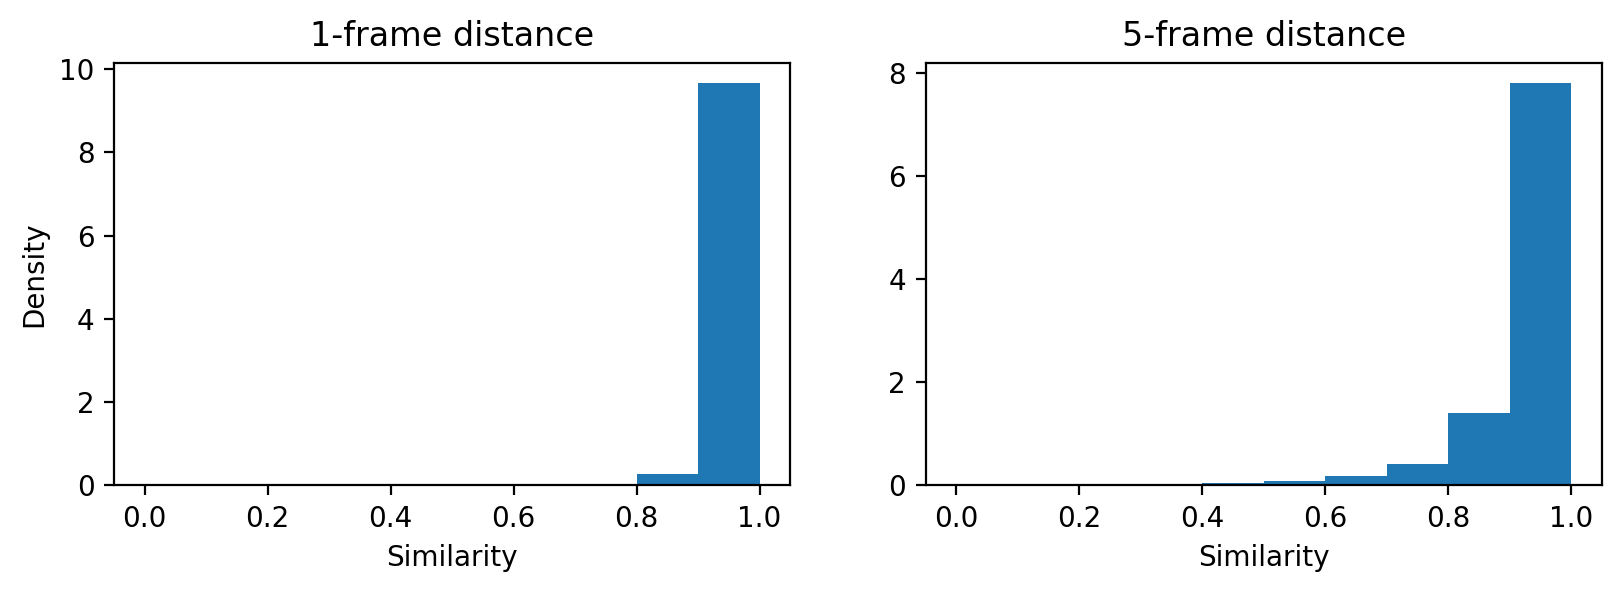

In [142]:
fig, axs = plt.subplots(1,2,figsize=(4.8*2,2.8),dpi=200)
axs[0].hist(res,density=True)
axs[0].set_xlabel("Similarity")
axs[0].set_ylabel("Density")
axs[0].set_title("1-frame distance")
axs[1].hist(res5,density=True)
axs[1].set_xlabel("Similarity")
axs[1].set_title("5-frame distance")
plt.savefig("bad_positives.pdf", bbox_inches="tight", pad_inches=0)

In [ ]:
plt.imshow(img2)

In [134]:
import matplotlib
matplotlib.__version__

'3.7.2'